In [9]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests # Para cargar datos desde URL
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# CODIGO PARA QUE NO SALGAN WARNINGS
import warnings

warnings.filterwarnings('ignore')

# Configuración de estilo para los gráficos
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 12

# Carga los datos CSV directamente en un DataFrame de pandas
df_clientes = datos = pd.read_csv('/content/datos_renombrados.csv')

print(df_clientes.head())


   cancelacion  genero  adulto_mayor  tiene_pareja  tiene_dependientes  \
0            0  Female             0             1                   1   
1            0    Male             0             0                   0   
2            1    Male             0             0                   0   
3            1    Male             1             1                   0   
4            1  Female             1             1                   0   

   tenencia  tiene_telefono lineas_multiples tipo_internet seguridad_online  \
0         9               1               No           DSL               No   
1         9               1              Yes           DSL               No   
2         4               1               No   Fiber optic               No   
3        13               1               No   Fiber optic               No   
4         3               1               No   Fiber optic               No   

   ... proteccion_dispositivo soporte_tecnico streaming_tv  \
0  ...            

#1.IDENTIFICAR Y MANIPULAR COLUMNAS CATEGÓRICAS

##1.1. IDENTIFICAR LAS COLUMNAS CATEGÓRICAS

In [3]:
columnas_categoricas = df_clientes.select_dtypes(include='object').columns.tolist()
if 'cancelacion' in columnas_categoricas:
    columnas_categoricas.remove('cancelacion')

# Construir el diccionario de mapeo
encoding_map = {}
for col in columnas_categoricas:
    # Obtener los valores únicos de la columna original
    original_values = df_clientes[col].unique().tolist()

    # Obtener la lista de nuevas columnas que se crearán a partir de la columna categórica original después de la codificación
    new_cols = [f'{col}_{value}' for value in original_values]

    # Si se usa drop_first=True en get_dummies, se eliminará la primera categoría.
    # Debemos tener esto en cuenta en el mapeo.
    if True: # Asumiendo que drop_first=True se usa más adelante
        if len(new_cols) > 1:
            # La primera categoría se eliminará, así que eliminamos el nombre de la columna correspondiente
            dropped_value = original_values[0]
            dropped_col_name = f'{col}_{dropped_value}'
            if dropped_col_name in new_cols:
                new_cols.remove(dropped_col_name)
            # El valor original eliminado es el que no está representado explícitamente por una nueva columna
            original_values_mapped = original_values[1:] # Excluir el primer valor

            # Crear el mapeo para los valores originales restantes a los nombres de las nuevas columnas
            col_mapping = dict(zip(original_values_mapped, new_cols))
            # Agregar el mapeo del valor eliminado para indicar que es la línea de base (todas las nuevas columnas son 0)
            col_mapping[dropped_value] = [new_col for new_col in [f'{col}_{value}' for value in original_values[1:]]] # Mapear a la lista de nuevas columnas que implica cuando todas son 0
            encoding_map[col] = col_mapping
        else:
             # Si solo hay un valor único, get_dummies no creará una nueva columna para él
             encoding_map[col] = {original_values[0]: []} # Mapear a una lista vacía de nuevas columnas
    else:
        # Si drop_first=False, mapear cada valor original a su nombre de columna correspondiente
        col_mapping = dict(zip(original_values, new_cols))
        encoding_map[col] = col_mapping



In [8]:
df_clientes_encoded.head()

,cancelacion,adulto_mayor,tiene_pareja,tiene_dependientes,tenencia,tiene_telefono,facturacion_electronica,cuota_mensual,cuota_total,cuentas_diarias,...,streaming_tv_No internet service,streaming_tv_Yes,streaming_peliculas_No internet service,streaming_peliculas_Yes,contrato_One year,contrato_Two year,metodo_pago_Credit card (automatic),metodo_pago_Electronic check,metodo_pago_Mailed check,cancelacion_numerica
0,0,0,1,1,9,1,1,65.6,593.30,2.187,...,False,True,False,False,True,False,False,False,True,0
1,0,0,0,0,9,1,0,59.9,542.40,1.997,...,False,False,False,True,False,False,False,False,True,0
2,1,0,0,0,4,1,1,73.9,280.85,2.463,...,False,False,False,False,False,False,False,True,False,1
3,1,1,1,0,13,1,1,98.0,1237.85,3.267,...,False,True,False,True,False,False,False,True,False,1
4,1,1,1,0,3,1,1,83.9,267.40,2.797,...,False,True,False,False,False,False,False,False,True,1


##1.2. APLICAR ONE-HOT ENCODING A LAS COLUMNAS CATEGÓRICAS

In [4]:
df_clientes_encoded = pd.get_dummies(df_clientes, columns=columnas_categoricas, drop_first=True)

# Mostrar el mapa de codificación para verificación (opcional)
print("Mapa de Codificación:")
print(encoding_map)

print("\nDataFrame después de One-Hot Encoding (df_clientes_encoded):")
print(df_clientes_encoded.head())

print("\nInformación después de la codificación:")
df_clientes_encoded.info()

Mapa de Codificación:
{'genero': {'Male': 'genero_Male', 'Female': ['genero_Male']}, 'lineas_multiples': {'Yes': 'lineas_multiples_Yes', 'No phone service': 'lineas_multiples_No phone service', 'No': ['lineas_multiples_Yes', 'lineas_multiples_No phone service']}, 'tipo_internet': {'Fiber optic': 'tipo_internet_Fiber optic', 'No': 'tipo_internet_No', 'DSL': ['tipo_internet_Fiber optic', 'tipo_internet_No']}, 'seguridad_online': {'Yes': 'seguridad_online_Yes', 'No internet service': 'seguridad_online_No internet service', 'No': ['seguridad_online_Yes', 'seguridad_online_No internet service']}, 'respaldo_online': {'No': 'respaldo_online_No', 'No internet service': 'respaldo_online_No internet service', 'Yes': ['respaldo_online_No', 'respaldo_online_No internet service']}, 'proteccion_dispositivo': {'Yes': 'proteccion_dispositivo_Yes', 'No internet service': 'proteccion_dispositivo_No internet service', 'No': ['proteccion_dispositivo_Yes', 'proteccion_dispositivo_No internet service']}, 's

#2.VERIFICACIÓN DE LA PROPORCIÓN DE CANCELACIÓN (CHURN)



In [16]:
proporcion_cancelacion = df_clientes_encoded['cancelacion'].value_counts(normalize=True) * 100

print("Proporción de clientes por Cancelación:")
print(proporcion_cancelacion)

# Evaluar si existe un desbalance menos del 10-20% de la clase minoritaria
clase_porcentage_minimo = proporcion_cancelacion.min()
if clase_porcentage_minimo < 20: # Umbral comúnmente utilizado, puede ajustarse
    print("\nExiste un desbalance significativo en la variable objetivo 'cancelación'.")
else:
    print("\nNo parece haber un desbalance significativo en la variable objetivo 'cancelación'.")

Proporción de clientes por Cancelación:
cancelacion
0    73.421502
1    26.578498
Name: proportion, dtype: float64

No parece haber un desbalance significativo en la variable objetivo 'cancelación'.


#3.NORMALIZACION DATAFRAME

In [45]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Identificar las columnas numéricas (excluyendo la variable objetivo 'cancelacion', que no es numérica)
columnas_numericas = df_clientes_encoded.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Inicializar el MinMaxScaler
scaler = MinMaxScaler()

# Normalización de columnas numéricas
df_clientes_encoded[columnas_numericas] = scaler.fit_transform(df_clientes_encoded[columnas_numericas])

# Mostrar las primeras filas e información del DataFrame normalizado
print("DataFrame df_clientes_encoded después de la normalización:")
display(df_clientes_encoded.head())
df_clientes_encoded.info()


DataFrame df_clientes_encoded después de la normalización:


,cancelacion,adulto_mayor,tiene_pareja,tiene_dependientes,tenencia,tiene_telefono,facturacion_electronica,cuota_mensual,cuota_total,cuentas_diarias,...,soporte_tecnico_Yes,streaming_tv_No internet service,streaming_tv_Yes,streaming_peliculas_No internet service,streaming_peliculas_Yes,contrato_One year,contrato_Two year,metodo_pago_Credit card (automatic),metodo_pago_Electronic check,metodo_pago_Mailed check
0,0.0,0.0,1.0,1.0,0.112676,1.0,1.0,0.471144,0.066294,0.471343,...,True,False,True,False,False,True,False,False,False,True
1,0.0,0.0,0.0,0.0,0.112676,1.0,0.0,0.414428,0.060420,0.414627,...,False,False,False,False,True,False,False,False,False,True
2,1.0,0.0,0.0,0.0,0.042254,1.0,1.0,0.553731,0.030239,0.553731,...,False,False,False,False,False,False,False,False,True,False
3,1.0,1.0,1.0,0.0,0.169014,1.0,1.0,0.793532,0.140670,0.793731,...,False,False,True,False,True,False,False,False,True,False
4,1.0,1.0,1.0,0.0,0.028169,1.0,1.0,0.653234,0.028687,0.653433,...,True,False,True,False,False,False,False,False,False,True


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 32 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   cancelacion                                 7032 non-null   float64
 1   adulto_mayor                                7032 non-null   float64
 2   tiene_pareja                                7032 non-null   float64
 3   tiene_dependientes                          7032 non-null   float64
 4   tenencia                                    7032 non-null   float64
 5   tiene_telefono                              7032 non-null   float64
 6   facturacion_electronica                     7032 non-null   float64
 7   cuota_mensual                               7032 non-null   float64
 8   cuota_total                                 7032 non-null   float64
 9   cuentas_diarias                             7032 non-null   float64
 10  genero_Male 

#4.CORRELACIÓN Y SELECCIÓN DE VARIABLES

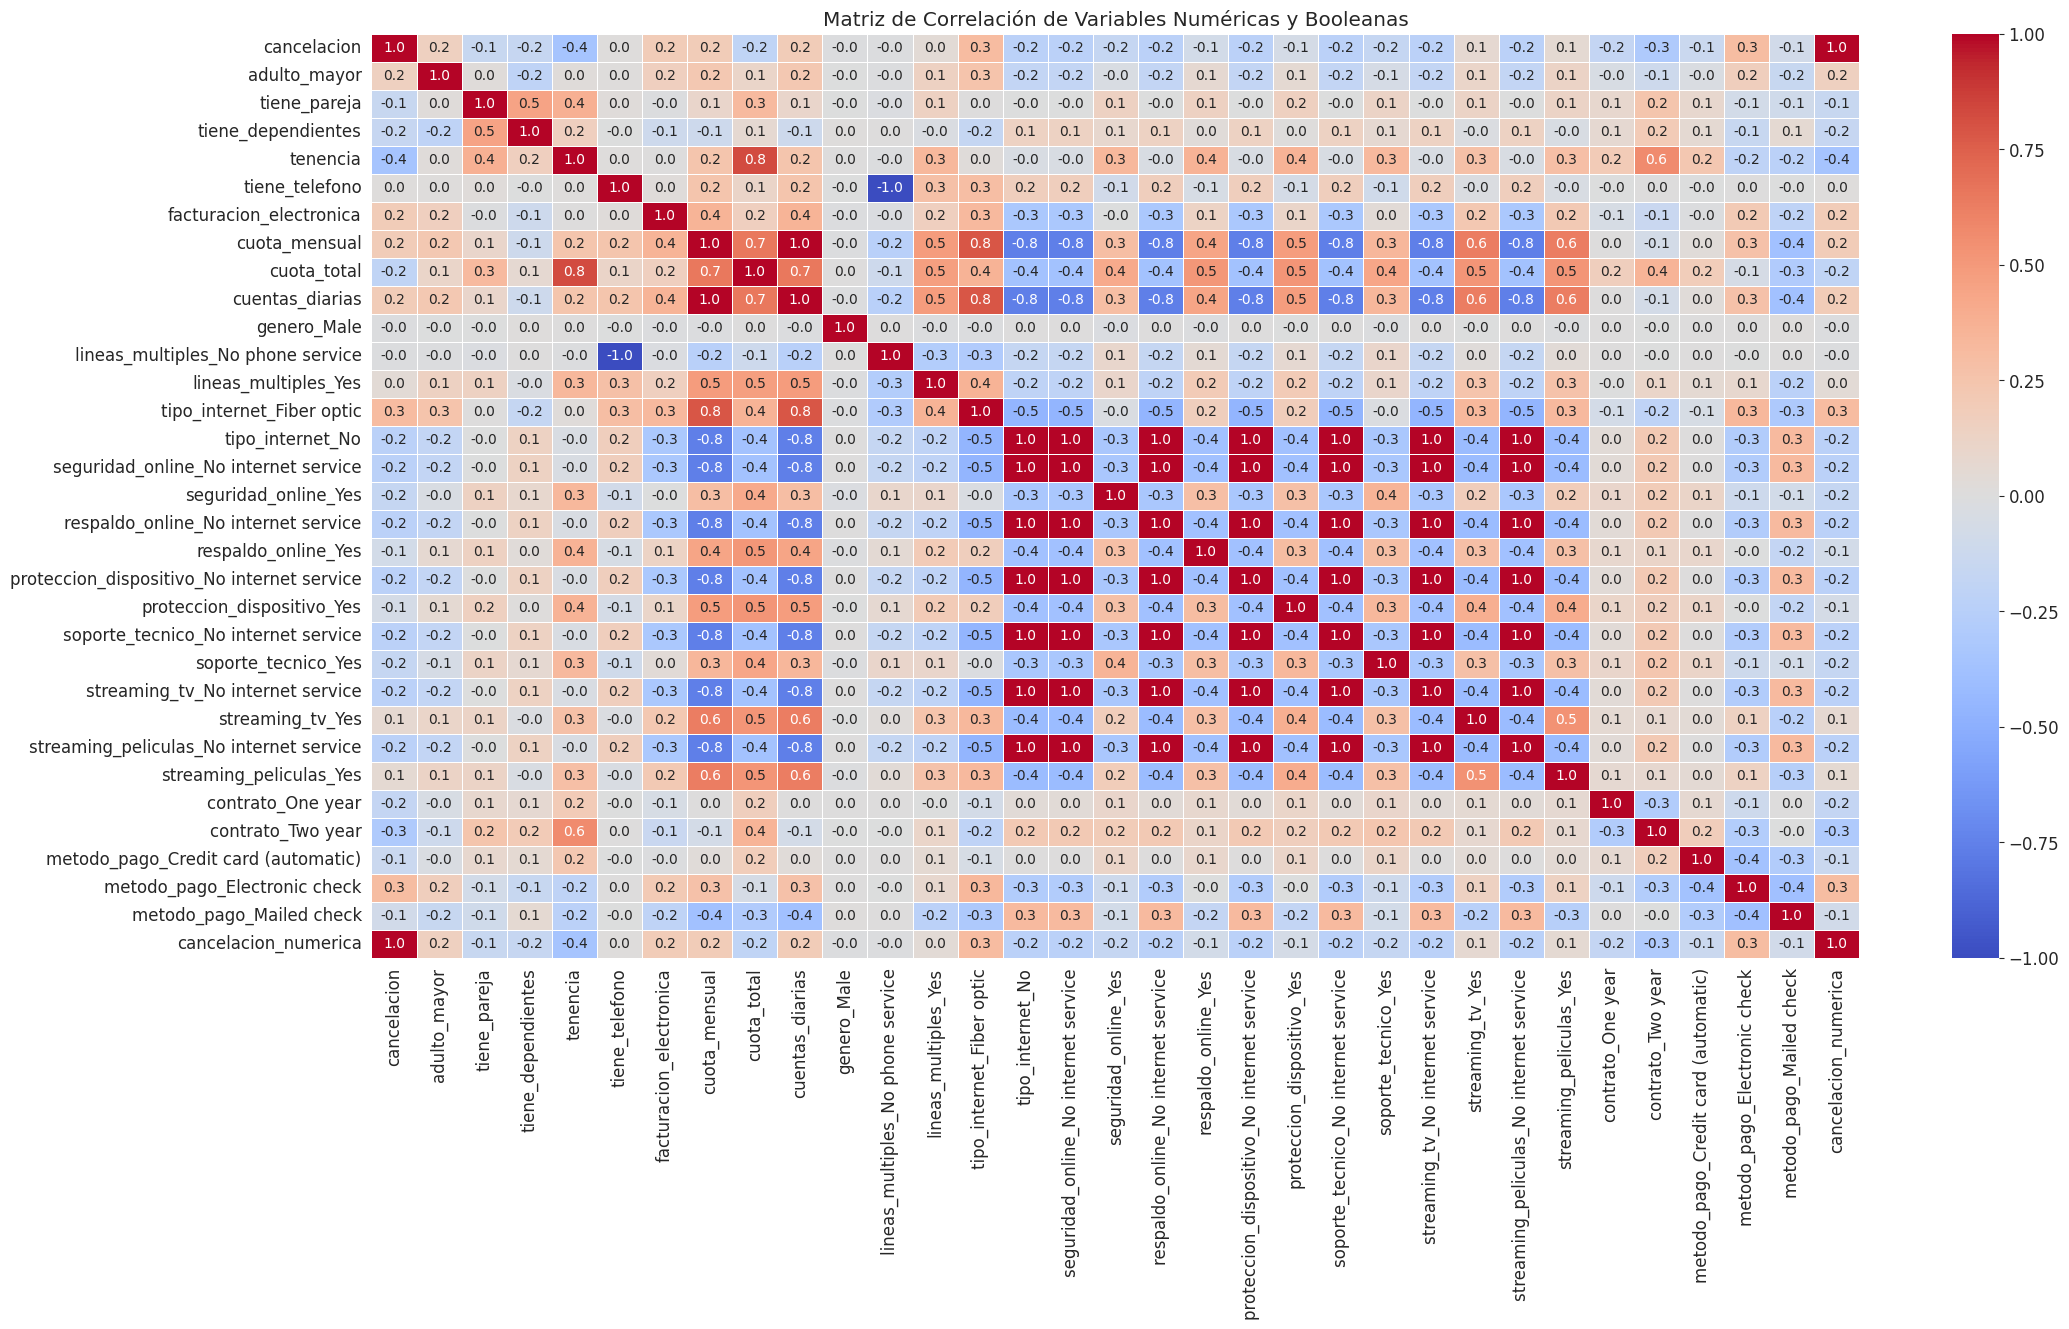


Correlación con cancelacion:
cancelacion                                   1.000000
cancelacion_numerica                          1.000000
tipo_internet_Fiber optic                     0.307463
metodo_pago_Electronic check                  0.301455
cuota_mensual                                 0.192858
cuentas_diarias                               0.192857
facturacion_electronica                       0.191454
adulto_mayor                                  0.150541
streaming_tv_Yes                              0.063254
streaming_peliculas_Yes                       0.060860
lineas_multiples_Yes                          0.040033
tiene_telefono                                0.011691
genero_Male                                  -0.008545
lineas_multiples_No phone service            -0.011691
proteccion_dispositivo_Yes                   -0.066193
respaldo_online_Yes                          -0.082307
metodo_pago_Mailed check                     -0.090773
metodo_pago_Credit card (automatic)

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Convertir la variable objetivo 'cancelacion' a numérico (0 para 'No', 1 para 'Yes')
df_clientes_encoded['cancelacion_numerica'] = df_clientes_encoded['cancelacion'].replace({'No': 0, 'Yes': 1, '': np.nan})

# Eliminar filas con valores nulos
df_clientes_corr = df_clientes_encoded.dropna(subset=['cancelacion_numerica']).copy()

# Convertir 'cancelacion_numerica' a tipo entero después de eliminar los NaN
df_clientes_corr['cancelacion_numerica'] = df_clientes_corr['cancelacion_numerica'].astype(int)

# Seleccionar solo las columnas numéricas y booleanas para la matriz de correlación
columnas_numericas_y_booleanas = df_clientes_corr.select_dtypes(include=[np.number, 'bool']).columns.tolist()

# Calcular la matriz de correlación
matrix_correlacion = df_clientes_corr[columnas_numericas_y_booleanas ].corr()

# Visualizar la matriz
plt.figure(figsize=(24, 12)) # Aumentar el tamaño de la figura
sns.heatmap(matrix_correlacion, annot=True, cmap='coolwarm', fmt=".1f", linewidths=.5, annot_kws={"size": 10}) # Ajustar tamaño
plt.title('Matriz de Correlación de Variables Numéricas y Booleanas')
plt.show()

# Mostrar las correlaciones
print("\nCorrelación con cancelacion:")
print(matrix_correlacion['cancelacion_numerica'].sort_values(ascending=False))

##4.1.COEFICIENTE DE CORRELACIÓN DE PEARSON ENTRE CADA VARIABLE Y 'CANCELACION_NUMERICA'

Estos resultados muestran el coeficiente de correlación de Pearson entre cada variable y la variable objetivo 'cancelacion_numerica' (donde 1 representa cancelación y 0 no cancelación).

**Coeficiente de Correlación:** Este valor varía entre -1 y 1.
- Un valor cercano a 1 indica una fuerte correlación positiva: a medida que el valor de la variable aumenta, la probabilidad de cancelación también tiende a aumentar.
- Un valor cercano a -1 indica una fuerte correlación negativa: a medida que el valor de la variable aumenta, la probabilidad de cancelación tiende a disminuir.
- Un valor cercano a 0 indica una correlación débil o nula.

**Análisis de las variables con mayor correlación (positiva):**

**tipo_internet_Fiber optic (0.307):**
- Tener servicio de fibra óptica tiene una correlación positiva moderada con la cancelación.
- Esto sugiere que los clientes con este tipo de internet son más propensos a cancelar.

**metodo_pago_Electronic check (0.301):**
- Utilizar el pago electrónico también muestra una correlación positiva moderada con la cancelación.
- Los clientes que pagan de esta manera podrían tener una mayor tendencia a irse.

**cuota_mensual (0.193), cuentas_diarias (0.193), facturacion_electronica (0.191):**
- Estas variables relacionadas con los costos y la facturación electrónica tienen correlaciones positivas más débiles, pero aún sugieren que costos mensuales más altos o la facturación electrónica podrían estar asociados con una mayor probabilidad de cancelación.

**adulto_mayor (0.151):**
- Ser un adulto mayor tiene una correlación positiva débil con la cancelación.

**Análisis de las variables con mayor correlación (negativa):**

**tenencia (-0.354):**
- La antigüedad o "tenencia" del cliente tiene la correlación negativa más fuerte con la cancelación.
- Esto es intuitivo: cuanto más tiempo lleva un cliente, menos probable es que cancele.

**contrato_Two year (-0.302):**
- Tener un contrato de dos años tiene una correlación negativa moderada. Los clientes con contratos más largos son menos propensos a cancelar, ya que están comprometidos por más tiempo.

**tipo_internet_No (-0.228), streaming_tv_No internet service (-0.228), etc.:** - Varias variables indicando la ausencia de ciertos servicios (como no tener servicio de internet, o no tener servicios de streaming si no tienen internet) tienen correlaciones negativas.
- Esto sugiere que los clientes con menos servicios o sin internet son menos propensos a cancelar (quizás porque tienen menos opciones o un servicio básico más estable).

**cuota_total (-0.199):**
- La cuota total acumulada tiene una correlación negativa débil. Esto puede parecer contradictorio con la cuota mensual, pero la cuota total está fuertemente correlacionada con la antigüedad (cuanto más tiempo, mayor la cuota total), lo que refuerza la idea de que los clientes más antiguos son menos propensos a cancelar.

**En conclusión:**

- Las variables con mayor impacto en la predicción de la cancelación, basándonos en la correlación, parecen ser la antigüedad del cliente (**tenencia**), el **tipo de contrato (dos años vs otros)**, el **tipo de internet (fibra óptica)** y el **método de pago (cheque electrónico).**

- Las **cuotas mensuales** y la **facturación electrónica** también muestran una relación positiva, aunque más débil.
- Las variables con correlaciones cercanas a cero (como el **género o si tiene teléfono**) probablemente tienen menos poder predictivo individualmente.

**Es importante recordar que la correlación solo mide relaciones lineales y no implica causalidad.**
- Aun así, estas variables son buenos candidatos para incluir en un modelo predictivo de cancelación.

#5.ANÁLISIS DIRIGIDO

Distribución de Cancelacion:
cancelacion
0    5163
1    1869
Name: count, dtype: int64


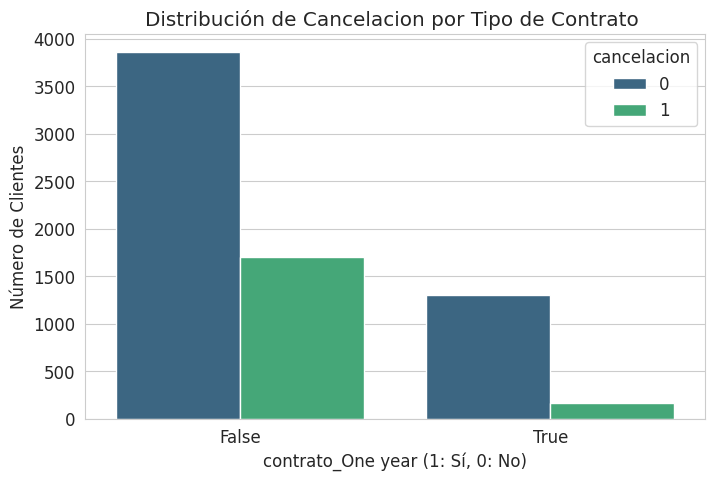

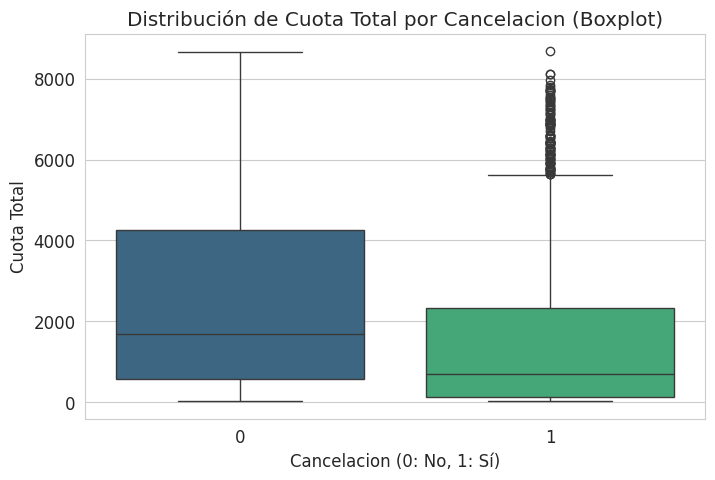

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convertir la columna 'cancelacion' a tipo entero
df_clientes_encoded['cancelacion'] = df_clientes_encoded['cancelacion'].astype(int)

print("Distribución de Cancelacion:")
print(df_clientes_encoded['cancelacion'].value_counts())

# Visualizar la relación entre 'contrato' y 'cancelacion'
plt.figure(figsize=(8, 5))#Ajustar tamaños
sns.countplot(data=df_clientes_encoded, x='contrato_One year', hue='cancelacion', palette='viridis')
plt.title('Distribución de Cancelacion por Tipo de Contrato ')
plt.xlabel('contrato_One year (1: Sí, 0: No)')
plt.ylabel('Número de Clientes')
plt.show()

# Visualizar la relación entre 'cuota_total' y 'cancelacion' usando un boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_clientes_encoded, x='cancelacion', y='cuota_total', palette='viridis')
plt.title('Distribución de Cuota Total por Cancelacion (Boxplot)')
plt.xlabel('Cancelacion (0: No, 1: Sí)')
plt.ylabel('Cuota Total')
plt.show()

##5.1.DISTRIBUCIÓN DE CANCELACIÓN POR TIPO DE CONTRATO (AÑO UNO):

- El gráfico de barras (countplot) muestra cuántos clientes cancelaron (barras verdes, 'cancelacion' = 1) y cuántos no cancelaron (barras azules, 'cancelacion' = 0) para cada categoría de la variable contrato_One year (Si tienen contrato de un año o no).

-Se puede observar que la mayoría de los clientes que no tienen un contrato de un año (contrato_One year = False) no cancelan (barra azul alta).
- Sin embargo, el número de cancelaciones (barra verde) es significativamente mayor en este grupo en comparación con los clientes que sí tienen un contrato de un año (contrato_One year = True).

- Para los clientes con un contrato de un año (contrato_One year = True), la gran mayoría no cancela, y el número de cancelaciones es muy bajo.

**Conclusión de este gráfico:**
- Los clientes con contratos de un año son mucho menos propensos a cancelar que aquellos con otros tipos de contrato (como mes a mes, que se representa en el grupo "False" después del one-hot encoding y drop_first=True).
- Esto refuerza la idea de que los contratos a largo plazo reducen la tasa de cancelación.

**Distribución de Cuota Total por Cancelación (Boxplot):**

- Este gráfico de caja (boxplot) muestra la distribución de la **cuota_total** (el cargo total acumulado) para los clientes que no cancelaron (0) y los que sí cancelaron (1).
- La "caja" central representa el rango intercuartílico (donde se encuentra el 50% medio de los datos).
- La línea dentro de la caja es la mediana. Las "líneas" (whiskers) se extienden para mostrar el rango de los datos, excluyendo los valores atípicos (puntos individuales).
- Observamos que la cuota_total para los clientes que no cancelaron (0) tiene una mediana y un rango intercuartílico más altos en comparación con los clientes que sí cancelaron (1).
- Los puntos individuales por encima de las líneas son valores atípicos.

**Conclusión de este gráfico:**
- Los clientes que cancelaron tienden a tener una **cuota total** acumulada menor en promedio en comparación con los clientes que se quedan.
- Esto podría estar relacionado con el hecho de que los clientes que se quedan generalmente tienen una antigüedad ("**tenencia**") mayor, lo que resulta en una **cuota total** más alta con el tiempo.
- Esto concuerda con la correlación negativa observada anteriormente entre la **tenencia y la cancelación**.

**En resumen**, estas visualizaciones confirman hallazgos importantes del análisis de correlación: los contratos de un año están asociados con una menor cancelación, y los clientes que cancelan tienden a tener una cuota total acumulada más baja, probablemente debido a una menor antigüedad.

#6.MODELADO PREDICTIVO

##6.1.SEPARACIÓN DE DATOS

In [38]:
from sklearn.model_selection import train_test_split

# Separar características (X) de la variable objetivo (y)
X = df_clientes_corr.drop('cancelacion_numerica', axis=1)
y = df_clientes_corr['cancelacion_numerica']

# Dividir datos en conjuntos de entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Forma del conjunto de entrenamiento (X_train):", X_train.shape)
print("Forma del conjunto de prueba (X_test):", X_test.shape)
print("Forma de las etiquetas de entrenamiento (y_train):", y_train.shape)
print("Forma de las etiquetas de prueba (y_test):", y_test.shape)

Forma del conjunto de entrenamiento (X_train): (5625, 32)
Forma del conjunto de prueba (X_test): (1407, 32)
Forma de las etiquetas de entrenamiento (y_train): (5625,)
Forma de las etiquetas de prueba (y_test): (1407,)


Los resultados que muestran corresponden a la división de los datos en conjuntos de entrenamiento y prueba utilizando la función train_test_split de Scikit-learn.

**Forma del conjunto de entrenamiento (X_train):** (5625, 32)

- Esto indica que el conjunto de datos de entrenamiento para las características (X_train) tiene 5625 filas y 32 columnas.
- Las 5625 filas representan el número de ejemplos de clientes que se utilizarán para entrenar el modelo.
- Las 32 columnas representan el número de características o variables (después de la codificación One-Hot y la normalización) que se usarán para predecir la cancelación.
- La variable objetivo ('cancelacion') ha sido excluida de este conjunto.

**Forma del conjunto de prueba (X_test):** (1407, 32)

-Esto indica que el conjunto de datos de prueba para las características (X_test) tiene 1407 filas y 32 columnas.
- Las 1407 filas representan el número de ejemplos de clientes que se utilizarán para evaluar el rendimiento del modelo después de haber sido entrenado.
- Estos datos no fueron vistos por el modelo durante el entrenamiento.
- Las 32 columnas son las mismas características que en el conjunto de entrenamiento.

**Forma de las etiquetas de entrenamiento (y_train):** (5625,)

- Esto indica que las etiquetas de la variable objetivo (y_train, que es 'cancelacion') para el conjunto de entrenamiento tienen 5625 filas.
- Esta es una serie o arreglo unidimensional donde cada elemento corresponde a la etiqueta de cancelación (0 o 1) para cada cliente en el conjunto de entrenamiento X_train.

**Forma de las etiquetas de prueba (y_test):** (1407,)

- Esto indica que las etiquetas de la variable objetivo (y_test, 'cancelacion') para el conjunto de prueba tienen 1407 filas.
- Similar a y_train, cada elemento es la etiqueta de cancelación real para cada cliente en el conjunto de prueba X_test.

**En resumen:**
- Estos resultados muestran que dividiste tu conjunto de datos original en un 80% para entrenamiento (5625 muestras) y un 20% para prueba (1407 muestras), manteniendo las 32 características para ambos conjuntos, además de las etiquetas de cancelación correspondientes.
- Esta división es un paso estándar para preparar los datos para el modelado predictivo y evaluar el modelo de manera justa.

#7.CREACIÓN DE MODELOS

##7.1. MODELO CON NORMALIZACIÓN

### 7.1.1. K-Nearest Neighbors (KNN)

In [39]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Inicializar modelo KNN
model_knn = KNeighborsClassifier(n_neighbors=5)

# Entrenar modelo con datos de entrenamiento normalizados
# Excluir la columna 'cancelacion'
X_train_numeric = X_train.drop('cancelacion', axis=1)
X_test_numeric = X_test.drop('cancelacion', axis=1)

model_knn.fit(X_train_numeric, y_train)

# Predicciones conjunto prueba
y_pred_knn = model_knn.predict(X_test_numeric)

# Evaluar rendimiento del modelo
print("Evaluación del modelo K-Nearest Neighbors (KNN):")
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_knn))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_knn))

Evaluación del modelo K-Nearest Neighbors (KNN):
Accuracy: 0.7647476901208244

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.85      0.84      1033
           1       0.56      0.52      0.54       374

    accuracy                           0.76      1407
   macro avg       0.70      0.69      0.69      1407
weighted avg       0.76      0.76      0.76      1407


Confusion Matrix:
[[882 151]
 [180 194]]


###7.1.2.Evaluación del modelo K-Nearest Neighbors (KNN):

**Exactitud (Accuracy):** 0.7647
- Esto significa que el modelo KNN clasificó correctamente aproximadamente el 76.47% del total de clientes en el conjunto de prueba.
- Es una medida general del rendimiento del modelo.

**Reporte de Clasificación:**
- Este reporte desglosa las métricas por cada clase (0: No Cancelación, 1: Cancelación).
**Precision (Clase 0 - No Cancelación):** 0.83
- De todos los clientes que el modelo predijo que no cancelarían, el 83% realmente no cancelaron.

**Recall (Clase 0 - No Cancelación):** 0.85
- De todos los clientes que no cancelaron en la realidad, el modelo identificó

*   Elemento de la lista
*   Elemento de la lista

correctamente al 85%.
- Esto indica que el modelo es bueno para identificar a los clientes que se quedarán.

**F1-score (Clase 0 - No Cancelación):** 0.84
- Es un promedio ponderado de la precisión y el recall para la clase "No Cancelación".
- Un F1-score alto (0.84) confirma el buen rendimiento del modelo para esta clase.

**Precision (Clase 1 - Cancelación):** 0.56
- De todos los clientes que el modelo predijo que sí cancelarían, el 56% realmente cancelaron.
- Esto significa que hay un 44% de "falsos positivos" (clientes predichos como cancelados que no lo hicieron).

**Recall (Clase 1 - Cancelación):** 0.52
- De todos los clientes que sí cancelaron en la realidad, el modelo identificó correctamente solo al 52%.
- Esto indica que hay un 48% de "falsos negativos" (clientes que cancelaron pero el modelo predijo que no lo harían).
- Al igual que Random Forest, este es un punto débil del modelo para identificar a la clase minoritaria.

**F1-score (Clase 1 - Cancelación):** 0.54
- El F1-score para la clase "Cancelación" (0.54) es significativamente más bajo que para la clase "No Cancelación", reflejando el desafío del modelo para manejar esta clase minoritaria.

**Confusion Matrix:** Esta matriz muestra el número de predicciones correctas e incorrectas.

[[882 151]

**882 (Verdaderos Negativos):** Clientes que no cancelaron y el modelo predijo correctamente que no cancelarían.
**151 (Falsos Positivos):** Clientes que no cancelaron pero el modelo predijo incorrectamente que cancelarían.

[180 194]]

**180 (Falsos Negativos):** Clientes que sí cancelaron pero el modelo predijo incorrectamente que no cancelarían.
**194 (Verdaderos Positivos):** Clientes que sí cancelaron y el modelo predijo correctamente que cancelarían.

**En resumen:**
- El modelo KNN tiene una precisión general aceptable (76.47%). Similar al Random Forest, su rendimiento es mejor para predecir la clase mayoritaria (No Cancelación) que para la clase minoritaria (Cancelación).
- Tiene una precisión y recall bajos para la clase 'Yes', lo que significa que a menudo predice incorrectamente que un cliente no cancelará cuando en realidad sí lo hace (muchos falsos negativos), aunque ligeramente menos que el Random Forest en este caso.
- Esto sugiere que el modelo KNN con la configuración actual también puede no ser el mejor para identificar a todos los clientes que realmente cancelarán.

##7.2.MODELO SIN NORMALIZACIÓN

###7.2.1 RANDOM FOREST

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Inicializar modelo Random Forest
# Ajustar parámetros n_estimators (número de árboles) y random_state
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Entrenar modelo con datos de entrenamiento
# Los modelos basados en árboles no requieren normalización, así que usamos X_train directamente.
model_rf.fit(X_train_numeric, y_train)

# Realizar predicciones conjunto de prueba
y_pred_rf = model_rf.predict(X_test_numeric)

# Evaluar el rendimiento del modelo
print("Evaluación del modelo Random Forest:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

Evaluación del modelo Random Forest:
Accuracy: 0.7945984363894811

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.90      0.87      1033
           1       0.65      0.50      0.56       374

    accuracy                           0.79      1407
   macro avg       0.74      0.70      0.71      1407
weighted avg       0.78      0.79      0.79      1407


Confusion Matrix:
[[931 102]
 [187 187]]


**Evaluación del modelo Random Forest:**

**Accuracy (Exactitud):** 0.7946
- Esto significa que el modelo Random Forest clasificó correctamente aproximadamente el 79.46% del total de clientes en el conjunto de prueba.
- Es una medida general del rendimiento del modelo.

**Classification Report:**
 Este reporte desglosa las métricas por cada clase (0: No Cancelación, 1: Cancelación).

**Precision (Clase 0 - No Cancelación):** 0.83
De todos los clientes que el modelo predijo que no cancelarían, el 83% realmente no cancelaron.

**Recall (Clase 0 - No Cancelación):** 0.90
- De todos los clientes que no cancelaron en la realidad, el modelo identificó correctamente al 90%.
- Esto indica que el modelo es muy bueno para identificar a los clientes que se quedarán.

**F1-score (Clase 0 - No Cancelación):** 0.87
- Es un promedio ponderado de la precisión y el recall para la clase "No Cancelación".
- Un F1-score alto (0.87) confirma el buen rendimiento del modelo para esta clase.

**Precision (Clase 1 - Cancelación):** 0.65
- De todos los clientes que el modelo predijo que sí cancelarían, el 65% realmente cancelaron.
- Esto significa que hay un 35% de "falsos positivos" (clientes predichos como cancelados que no lo hicieron).

**Recall (Clase 1 - Cancelación):** 0.50
- De todos los clientes que sí cancelaron en la realidad, el modelo identificó correctamente solo al 50%.
- Esto indica que hay un 50% de "falsos negativos" (clientes que cancelaron pero el modelo predijo que no lo harían).
- Este es un punto débil del modelo para identificar a la clase minoritaria.

**F1-score (Clase 1 - Cancelación):** 0.56
- El F1-score para la clase "Cancelación" (0.56) es significativamente más bajo que para la clase "No Cancelación", reflejando el desafío del modelo para manejar esta clase minoritaria.

**Confusion Matrix:**
- Esta matriz muestra el número de predicciones correctas e incorrectas.

[[931 102]

**931 (Verdaderos Negativos):** Clientes que no cancelaron y el modelo predijo correctamente que no cancelarían.
**102 (Falsos Positivos):** Clientes que no cancelaron pero el modelo predijo incorrectamente que cancelarían.

[187 187]]

**187 (Falsos Negativos):** Clientes que sí cancelaron pero el modelo predijo incorrectamente que no cancelarían.
**187 (Verdaderos Positivos):** Clientes que sí cancelaron y el modelo predijo correctamente que cancelarían.

**En resumen:**
- El modelo Random Forest tiene una buena exactitud general y es muy efectivo prediciendo a los clientes que no cancelarán.
- Sin embargo, tiene dificultades para identificar a los clientes que sí cancelarán, como lo indican su menor precisión y recall (especialmente el recall del 50%) para la clase **cancelación**.
- Esto significa que el modelo pasa por alto a una parte significativa de los clientes que finalmente cancelan.

###7.2.2. EVALUACIÓN DEL MODELO K-NEAREST NEIGHBORS (KNN)

In [41]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Realizar predicciones en el conjunto de prueba con el modelo KNN
y_pred_knn = model_knn.predict(X_test_numeric) # Usamos X_test_numeric como antes

# Evaluar el rendimiento del modelo KNN
print("Evaluación del modelo K-Nearest Neighbors (KNN):")
print("Exactitud (Accuracy):", accuracy_score(y_test, y_pred_knn))
print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred_knn))
print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred_knn))

Evaluación del modelo K-Nearest Neighbors (KNN):
Exactitud (Accuracy): 0.7647476901208244
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.83      0.85      0.84      1033
           1       0.56      0.52      0.54       374

    accuracy                           0.76      1407
   macro avg       0.70      0.69      0.69      1407
weighted avg       0.76      0.76      0.76      1407

Matriz de Confusión:
[[882 151]
 [180 194]]


###7.2.3. EVALUACIÓN DEL MODELO RANDOM FOREST

In [42]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Realizar predicciones  conjunto de prueba con Random Forest
y_pred_rf = model_rf.predict(X_test_numeric)

# Evaluar rendimiento modelo Random Forest
print("Evaluación del modelo Random Forest:")
print("Exactitud (Accuracy):", accuracy_score(y_test, y_pred_rf))
print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred_rf))
print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred_rf))

Evaluación del modelo Random Forest:
Exactitud (Accuracy): 0.7945984363894811
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.83      0.90      0.87      1033
           1       0.65      0.50      0.56       374

    accuracy                           0.79      1407
   macro avg       0.74      0.70      0.71      1407
weighted avg       0.78      0.79      0.79      1407

Matriz de Confusión:
[[931 102]
 [187 187]]


##7.3.COMPARACIÓN Y ANÁLISIS CRÍTICO DE MODELOS

| MÉTRICA                                  | KNN   | RANDOM FOREST | OBSERVACIONES                                                                 |
|------------------------------------------|-------|---------------|-------------------------------------------------------------------------------|
| Exactitud (Accuracy)                     | 0.76  | 0.79          | Random Forest tiene una precisión general ligeramente mayor que KNN.          |
| Precision (Clase 'Yes' - cancelación)    | 0.56  | 0.65          | Random Forest es mejor identificando correctamente a los clientes que cancelan entre todas sus predicciones 'Yes'. |
| Recall (Clase 'Yes' - cancelación)       | 0.52  | 0.50          | KNN identifica ligeramente más clientes que cancelan (Verdaderos Positivos) de todos los que realmente cancelan. |
| F1-score (Clase 'Yes' - cancelación)     | 0.54  | 0.56          | Random Forest tiene un mejor equilibrio entre precisión y recall para la clase 'Yes'. |
| Precision (Clase 'No' - no cancelación)  | 0.83  | 0.83          | Ambos modelos tienen una precisión similar para predecir clientes que no cancelan. |
| Recall (Clase 'No' - no cancelación)     | 0.85  | 0.90          | Random Forest es significativamente mejor identificando clientes que no cancelan de todos los que no cancelan. |
| F1-score (Clase 'No' - no cancelación)   | 0.84  | 0.87          | Random Forest tiene un mejor equilibrio para la clase 'No'.                   |
| Falsos Positivos (FP)                    | 151   | 102           | Random Forest comete menos errores al predecir 'Yes' cuando la realidad es 'No'. |
| Falsos Negativos (FN)                    | 180   | 187           | KNN comete ligeramente menos errores al predecir 'No' cuando la realidad es 'Yes'. |
| Verdaderos Positivos (TP)                | 194   | 187           | KNN identifica ligeramente más clientes que cancelan correctamente.           |
| Verdaderos Negativos (TN)                | 882   | 931           | Random Forest identifica correctamente a más clientes que no cancelan.        |

Basado en el cuadro comparativo y las métricas de rendimiento para predecir la cancelación de clientes ('Yes'), aquí tienes un análisis crítico y una conclusión:

**Análisis Crítico:**

**Exactitud General (Accuracy):**
- El modelo Random Forest tiene una exactitud general ligeramente superior (0.79 vs 0.76), lo que indica que clasifica correctamente una proporción mayor de clientes en general.

**Enfoque en la Cancelación (Clase 'Yes'):**
Aquí es donde radica la diferencia crucial para este problema.

**Precision (Clase 'Yes'):**
- Random Forest tiene una precisión notablemente mayor (0.65 vs 0.56).
- Esto significa que, cuando el modelo Random Forest predice que un cliente va a cancelar, es más probable que esa predicción sea correcta en comparación con el modelo KNN.
- Esto es valioso para no invertir recursos de retención en clientes que no planean irse (reduciendo falsos positivos).

**Recall (Clase 'Yes'):**
- El modelo KNN tiene un recall ligeramente superior (0.52 vs 0.50).
- Esto indica que el modelo KNN es marginalmente mejor identificando a los clientes que realmente van a cancelar de todos los clientes que cancelan.
- Un recall bajo en la clase positiva (cancelación) significa que el modelo tiene muchos "falsos negativos" (clientes que cancelan pero el modelo predice que no lo harán), lo cual es un problema significativo si el objetivo es identificar a todos los clientes propensos a la cancelación para aplicar estrategias de retención.

**F1-Score (Clase 'Yes'):**
- El F1-score, que equilibra precisión y recall, es ligeramente mejor para Random Forest (0.56 vs 0.54), lo que sugiere que, en general, tiene un mejor balance para la clase de interés (cancelación).

**Rendimiento en la No Cancelación (Clase 'No'):**
-  Ambos modelos son muy buenos prediciendo a los clientes que no cancelan, con métricas de precisión y recall altas y similares, aunque Random Forest tiene un recall ligeramente superior (0.90 vs 0.85), lo que reduce los falsos positivos en esta clase.

**Falsos Positivos y Falsos Negativos:**
- Random Forest tiene menos falsos positivos (102 vs 151), lo que significa que comete menos errores al predecir incorrectamente que un cliente va a cancelar. KNN tiene ligeramente menos falsos negativos (180 vs 187), lo que significa que comete ligeramente menos errores al no identificar a clientes que sí cancelan.

**Conclusión:**
- Considerando que el objetivo principal en un problema de predicción de cancelación de clientes suele ser identificar correctamente a los clientes propensos a cancelar para aplicar medidas de retención, el modelo Random Forest parece ser ligeramente mejor en este escenario.

- Aunque el modelo KNN identifica a un número marginalmente mayor de verdaderos positivos (clientes que cancelan correctamente), el modelo Random Forest ofrece una mayor precisión en sus predicciones de cancelación (reduce los falsos positivos en la clase 'Yes') y una mejor exactitud general.

- La elección final entre los modelos dependerá de la prioridad del negocio: si es más costoso un falso positivo (gastar recursos en retener a alguien que no se iba a ir) o un falso negativo (perder a un cliente que se iba a ir y no fue identificado).
- En muchos casos de cancelación, reducir los falsos positivos para optimizar las campañas de retención es crucial, lo que inclinaría la balanza a favor de Random Forest en este caso, a pesar de su ligero menor recall en la clase de cancelación.
- Se podrían explorar técnicas adicionales para mejorar el recall de la clase minoritaria en Random Forest, como ajustar los pesos de las clases o probar otros algoritmos.

#8.ANÁLISIS DE VARIABLES RELEVANTES PARA LA PREDICCIÓN DE CANCELACIÓN (CHURN)

Basándonos en la exploración inicial de los datos, el análisis de correlación y las visualizaciones dirigidas, podemos identificar y discutir las variables que parecen tener una influencia más significativa en la probabilidad de que un cliente cancele su servicio. Es crucial entender no solo qué variables están relacionadas con la cancelación, sino también cómo se relacionan y por qué podrían ser importantes desde una perspectiva de negocio.

**Variables Clave y su Relación con la Cancelación (Churn):**

**TENENCIA**

**Hallazgo:**

- El análisis de correlación mostró una fuerte correlación negativa (-0.354) entre la antigüedad (tenencia) y la cancelación.
-La visualización del boxplot de **cuota_total por cancelación** también respaldó esta idea indirectamente, ya que los clientes que **no cancelan** tienden a tener una **cuota_total más alta**, lo cual está fuertemente relacionado con una mayor antigüedad.

**Análisis Crítico:**

- Esta es una de las variables más intuitivas y consistentemente importantes en la predicción de cancelación.
- Los clientes que llevan más tiempo con la empresa generalmente han establecido una relación más sólida, están más acostumbrados al servicio y es menos probable que busquen alternativas de inmediato.
- Han superado las posibles frustraciones iniciales y han encontrado valor a largo plazo.
-Una baja **tenencia**, por el contrario, indica que el cliente aún se encuentra en una fase temprana de su relación con la empresa, donde la percepción del valor y la satisfacción pueden ser más volátiles.
- Es más fácil para un cliente nuevo irse si no cumple sus expectativas iniciales.
-Por lo tanto, la tenencia es un predictor fundamental de la lealtad del cliente.

**Tipo de Contrato:**

**Hallazgo:**

-El análisis de correlación mostró correlaciones negativas significativas con los contratos a largo plazo: **contrato_Two year** (-0.302) y **contrato_One year** (-0.178).
-La visualización del countplot para contrato_One year demostró claramente que los clientes con **contratos de un año (y por extensión, los de dos años) ** tienen una tasa de **cancelación mucho menor** en comparación con aquellos sin este tipo de contrato (principalmente contratos mes a mes).

**Análisis Crítico:**

- El **tipo de contrato** es un indicador directo del compromiso del cliente con la empresa.
- Un contrato a largo plazo implica una obligación contractual que disuade la **cancelación** prematura.
-Los clientes que eligen **contratos de uno o dos años** probablemente ya perciben un valor significativo en el servicio o están buscando estabilidad en sus costos.
-Los **contratos mes a mes**, por otro lado, ofrecen flexibilidad total, lo que facilita a los clientes cambiar de proveedor si encuentran una oferta mejor, experimentan problemas con el servicio o simplemente ya no necesitan el servicio.
-La fuerza de la correlación negativa con los **contratos de dos años** es particularmente importante, subrayando que un compromiso a más largo plazo es un fuerte indicador de retención.

**Tipo de Internet (Fibra Óptica vs. Otros/Sin Internet):**

**Hallazgo:**

- La variable **tipo_internet_Fiber optic** mostró una correlación positiva moderada (0.307) con la **cancelación**, mientras que **tipo_internet_No** tuvo una correlación negativa (-0.228).

**Análisis Crítico:**

- Este hallazgo es interesante y puede reflejar varios factores. Los servicios de **fibra óptica** suelen ser más rápidos y, a menudo, más caros.
-Los clientes que optan por fibra pueden tener mayores expectativas de rendimiento y pueden ser más sensibles a problemas de servicio o a los costos si perciben que el valor no justifica el precio.
-El mercado de fibra óptica puede ser más competitivo, con otros proveedores ofreciendo alternativas atractivas.
-Por otro lado, los clientes **sin servicio de internet (tipo_internet_No)** tienen una correlación **negativa** con la **cancelación**, lo que sugiere que aquellos que solo tienen servicios básicos (como teléfono) son menos propensos a irse.
-Esto podría deberse a que tienen menos opciones de proveedores para solo servicios telefónicos o sus necesidades son más simples y menos propensas a la insatisfacción.
-La correlación de la fibra óptica resalta un segmento de clientes de alto valor pero potencialmente de alto riesgo.

**Método de Pago (Cheque Electrónico):**

**Hallazgo:**

 La variable **metodo_pago_Electronic check** mostró una correlación positiva moderada (0.301) con la **cancelación**.
 -Otros métodos de pago como **metodo_pago_Credit card (automatic)** (-0.135) y **metodo_pago_Mailed check** (-0.091) tuvieron correlaciones negativas más débiles.

**Análisis Crítico:**

- La fuerte correlación positiva con el **cheque electrónico** es un patrón común observado en muchos conjuntos de datos de cancelación.
- Los clientes que utilizan cheques electrónicos tienden a ser más propensos a cancelar.
- Esto podría deberse a que este **método de pago** es a menudo elegido por clientes con **contratos mes a mes** (que ya son más propensos a cancelar) o puede indicar un segmento demográfico o de comportamiento particular.
-También podría ser que los problemas técnicos o la falta de automatización completa asociados con los **cheques electrónicos** generen fricción que contribuye a la insatisfacción.
- Los **métodos de pago automáticos** (tarjeta de crédito, transferencia bancaria) muestran correlaciones negativas, lo que sugiere que la automatización del pago puede estar asociada con una mayor retención, quizás por conveniencia o porque los clientes más comprometidos optan por la automatización.

**Cuota Mensual y Facturación Electrónica:**

**Hallazgo:**

- La **cuota_mensual** (0.193) y **facturacion_electronica** (0.191) mostraron correlaciones positivas más débiles pero aún relevantes con la cancelación.

**Análisis Crítico:**

- Si bien no son tan fuertes como la **tenencia o el tipo de contrato**, estas variables sugieren que **cuotas mensuales** más altos y la preferencia por la **facturación electrónica** están asociados con una mayor probabilidad de cancelación.
-Clientes con facturas mensuales elevadas pueden ser más sensibles a los precios y más propensos a buscar alternativas más económicas.
-La **facturación electrónica**, aunque conveniente para muchos, podría estar asociada con clientes que son más activos en línea y, por lo tanto, más expuestos a ofertas de la competencia o más propensos a gestionar sus servicios digitalmente, incluida la cancelación.

**Servicios Adicionales (Seguridad Online, Respaldo Online, Soporte Técnico, Streaming TV/Películas):**

**Hallazgo:**

- Varias variables indicando la ausencia de estos servicios (por ejemplo, **seguridad_online_No internet service, streaming_tv_No internet service)** mostraron correlaciones negativas significativas (alrededor de -0.228), lo cual está fuertemente relacionado con la **ausencia de servicio de internet** en general.
- Las variables que indican la **presencia de estos servicios** (por ejemplo, **seguridad_online_Yes** (-0.171), **soporte_tecnico_Yes** (-0.165), **respaldo_online_Yes** (-0.082), **proteccion_dispositivo_Yes** (-0.066)) mostraron correlaciones negativas más débiles.
- **streaming_tv_Yes** (0.063) y **streaming_peliculas_Yes** (0.061) tuvieron correlaciones positivas débiles.

**Análisis Crítico:**

- Los servicios adicionales tienen un impacto variado.
-La correlación negativa de la ausencia de estos servicios (cuando **no hay servicio de internet**) refuerza la idea de que los clientes con servicios básicos son menos propensos a cancelar.
-La correlación negativa de la presencia de servicios como **seguridad, respaldo y soporte técnico** sugiere que estos servicios pueden actuar como **"factores de adherencia"** que aumentan la lealtad del cliente.
-Los clientes que utilizan estos servicios pueden percibirlos como valiosos y una razón para quedarse.
-Curiosamente, los servicios de **streaming_tv y películas** tienen correlaciones positivas débiles, lo que podría indicar que, si bien son populares, no necesariamente garantizan la retención y podrían estar asociados con clientes que buscan entretenimiento y pueden cambiar fácilmente si encuentran mejores opciones en otro lugar.

**Variables con Correlación Débil (Género, Tiene Teléfono):**

**Hallazgo:**

- Variables como **genero_Male** (-0.008) y **tiene_telefono** (0.012) mostraron correlaciones muy cercanas a cero.

**Análisis Crítico:**

- Estas variables parecen tener poca o ninguna relación lineal directa con la **cancelación**.
-Si bien podrían tener interacciones complejas con otras variables, individualmente no son fuertes predictores de cancelación según este análisis de correlación.



#9.CONCLUSIÓN GENERAL DEL ANÁLISIS DE VARIABLES:

El análisis de correlación y las visualizaciones confirman que la **predicción de la cancelación** de clientes es un problema complejo influenciado por una combinación de factores. Las variables más relevantes y con mayor poder predictivo parecen estar relacionadas con:

El compromiso a largo plazo:** tenencia** (antigüedad) y **tipo de contrato** (especialmente **contratos de dos años**) son los predictores más fuertes de la retención.

**Tipo de servicios utilizados:**

-El **tipo de internet (fibra óptica** como riesgo, **no internet** como bajo riesgo) y la presencia de servicios de valor añadido como **seguridad, respaldo y soporte técnico** influyen en la probabilidad de cancelación.

**Comportamiento de pago y costos:**

- El método de pago (**cheque electrónico** como riesgo, **métodos automáticos** como retención) y las **cuotas mensuales** más altas están asociados con una mayor propensión a cancelar.
-La modelación predictiva (como la realizada con **KNN y Random Forest**) utiliza estas relaciones para construir un modelo que pueda estimar la **probabilidad de cancelación** para un cliente dado.
- Los modelos como **Random Forest**, que pueden capturar relaciones no lineales e interacciones entre variables, a menudo funcionan bien en este tipo de problemas.
-La dificultad para predecir la clase minoritaria (**cancelación**) en ambos modelos subraya la necesidad de **técnicas adicionales** si el objetivo principal es **identificar a todos los clientes en riesgo** (mejorar el recall de la clase 'Yes'), como el **sobremuestreo de la clase minoritaria**, el submuestreo de la clase mayoritaria, o el uso de algoritmos más adecuados para datos desbalanceados.

**En resumen**, un modelo efectivo de predicción de cancelación debe dar un peso significativo a la antigüedad del cliente y al tipo de contrato, al tiempo que considera el tipo de internet, el método de pago y los servicios adicionales como indicadores importantes del comportamiento y riesgo de cancelación del cliente.

#10.PLANES ESTRATÉGICOS PARA REDUCIR CANCELACIÓN (CHURN)

##10.1.RESUMEN EJECUTIVO DE ESTRATEGIAS DE RETENCIÓN
---

## **ESTRATEGIA #1: RETENCIÓN TEMPRANA Y MITIGACIÓN DE RIESGOS INICIALES**

###**Objetivo Principal**
Dirigirse a **nuevos clientes con tenencia < 9 meses**, especialmente aquellos con características de alto riesgo:
- Contratos mes a mes
- Método de pago cheque electrónico
- Fibra óptica sin servicios adicionales
- Adultos mayores

###**Acciones Específicas**

####**Programa de Onboarding Mejorado**
- **Tutoriales personalizados** por segmento (especial atención a adultos mayores y servicios complejos como fibra óptica)
- **Soporte técnico proactivo** en las primeras semanas
- **Línea de contacto dedicada** para nuevas activaciones

####**Detección Temprana de Insatisfacción**
- **Encuestas de satisfacción programadas** a los 15 días, 3 meses y 6 meses
- **Sistema de alertas** para identificar problemas antes de que escalen a cancelaciones

####**Incentivos para Compromiso a Largo Plazo**
- **Descuentos significativos** para clientes mes a mes que cambien a contratos anuales
- **Servicios premium gratuitos** por tiempo limitado como incentivo de conversión

###**KPIs Clave**
- Reducción de tasa de cancelación en clientes < 9 meses
- % de nuevos clientes que migran a contratos a largo plazo
- Puntuaciones de satisfacción temprana

---

##**ESTRATEGIA #2: ACTIVACIÓN DE SERVICIOS DE VALOR Y ENGAGEMENT CONTINUO**

###**Objetivo Principal**
Maximizar el engagement de clientes con:
- **Bajo engagement** (< 1.2 cuentas diarias)
- **Servicios de internet sin complementos** (sin Seguridad Online, Protección de Dispositivo o Soporte Técnico)

### **Acciones Específicas**

####**Campañas de Activación Digital**
- **Educación sobre beneficios** de servicios que reducen churn
- **Canales múltiples**: email, SMS, tutoriales web/app, webinars
- **Contenido adaptado** por segmento demográfico

####**Ofertas de Paquetes Estratégicos**
- **Bundles atractivos**: Internet + Seguridad + Protección a precio preferencial
- **Promociones cruzadas** basadas en el perfil de uso del cliente

####**Evaluación de Valor Percibido**
- **Análisis profundo** de por qué clientes de alto gasto (Fibra Óptica) no perciben valor suficiente
- **Ajustes en comunicación** de propuesta de valor

### **KPIs Clave**
- Aumento % de adopción de servicios complementarios
- Mejora en puntuación de engagement
- Reducción de churn en segmentos de bajo engagement previo

---

##**ESTRATEGIA #3: SEGMENTACIÓN POR RIESGO Y VALOR PARA RETENCIÓN DIRIGIDA**

###**Matriz de Segmentación**

####**ALTO RIESGO + ALTO VALOR**
*Ejemplo: Fibra Óptica + Alto gasto + Contrato mes a mes + Cheque Electrónico*
- **Programa VIP de retención proactiva**
- **Gestor de cuentas dedicado**
- **Ofertas personalizadas** para migrar a contratos largos y pago automático
- **Resolución prioritaria** de problemas

####**ALTO RIESGO + VALOR MODERADO/BAJO**
*Ejemplo: Contrato mes a mes + Cheque Electrónico*
- **Campañas masivas segmentadas**
- **Descuentos temporales**
- **Beneficios por cambio** de método de pago
- **Simplificación de procesos**

####**BAJO RIESGO + ALTO VALOR**
*Ejemplo: Contrato 2 años + Pago Automático + Fibra + Servicios Adicionales*
- **Programas de fidelización**
- **Ofertas exclusivas por lealtad**
- **Acceso anticipado** a nuevos servicios
- **Comunicación VIP personalizada**

####**BAJO RIESGO + BAJO VALOR**
*Ejemplo: Sin internet + Bajo gasto*
- **Ofertas de upgrade** a planes básicos DSL
- **Énfasis en facilidad de uso** y bajo costo
- **Mantenimiento** de experiencia positiva actual

---

##**ESTRATEGIA #4: REVISIÓN ESTRATÉGICA DE PRECIOS Y PROPUESTA DE VALOR**

###**Análisis y Optimización**

####**Revisión de Estructura de Precios**
- **Análisis más allá** del umbral de $35 mensual
- **Enfoque en segmentos** de alto riesgo independiente de cuota actual
- **Evaluación precio-valor percibido** especialmente en Fibra Óptica

####**Creación de Planes de Entrada Estratégicos**
- **Ofertas para nuevos clientes** que fomenten contratos largos desde el inicio
- **Incentivos automáticos** para métodos de pago preferenciales

####**Bundling de Servicios de Valor**
- **Paquetes integrados** con servicios de seguridad y soporte
- **Precios atractivos** que reduzcan sensibilidad al costo individual
- **Propuesta de valor sólida** y comunicada claramente

####**Comunicación del Valor Total**
- **Enfoque holístico**: velocidad, seguridad, soporte, fiabilidad
- **Justificación clara** especialmente para servicios premium como Fibra Óptica
- **Educación continua** sobre beneficios recibidos

---

##**OBJETIVOS ESTRATÉGICOS GENERALES**

###**Metas Cuantificables**
1. **Reducir tasa de cancelación** en segmentos de alto riesgo identificados
2. **Mejorar percepción de valor** en segmentos de alto gasto mensual
3. **Aumentar adopción** de contratos a largo plazo y métodos de pago automáticos
4. **Incrementar engagement** y uso de servicios de valor añadido

###**Segmentos Prioritarios (Según Datos del Análisis)**
- **CRÍTICO**: Contrato mes a mes + Cheque electrónico = **53.73% de cancelación**
- **ALTO RIESGO**: Fibra óptica sin servicios adicionales = **55.42% de cancelación**
- **OBJETIVO**: Contrato 2 años + Cheque postal = **0.80% de cancelación** (modelo a replicar)

---

##**IMPLEMENTACIÓN Y SEGUIMIENTO**

###**Fases de Implementación**
1. **Fase 1 (0-3 meses)**: Implementar detección temprana y onboarding mejorado
2. **Fase 2 (3-6 meses)**: Lanzar campañas de activación y bundling de servicios
3. **Fase 3 (6-12 meses)**: Ejecutar segmentación completa y programas VIP
4. **Fase 4 (12+ meses)**: Optimización continua y revisión estratégica de precios

### **Monitoreo Continuo**
- **Dashboards en tiempo real** de métricas de churn por segmento
- **Alertas automáticas** para clientes en riesgo
- **Reportes mensuales** de efectividad de cada estrategia
- **Análisis trimestral** de ROI y ajustes estratégicos

---

*Este plan integral aborda los factores de riesgo más críticos identificados en el análisis, priorizando acciones específicas y medibles para los segmentos de mayor vulnerabilidad a la cancelación.*